## Importing neccessary modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA,ARIMA
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import adfuller,acf,pacf
import seaborn as sns

from statsmodels.tsa.api import SimpleExpSmoothing
import warnings
warnings.filterwarnings('ignore')

from pmdarima.arima import auto_arima
#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from sklearn.metrics import mean_squared_error
import statsmodels.api as sm


## Loading data

In [2]:
train=pd.read_csv(r"K:\Desktop\NIIT\tables\tables\DS3_C1_S3_DailyDelhiClimateTrain_Data_Practice.csv",parse_dates=['date'])
test=pd.read_csv(r"K:\Desktop\NIIT\tables\tables\DS3_C1_S3_DailyDelhiClimateTest_Data_Practice.csv",parse_dates=['date'])
train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [3]:
test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


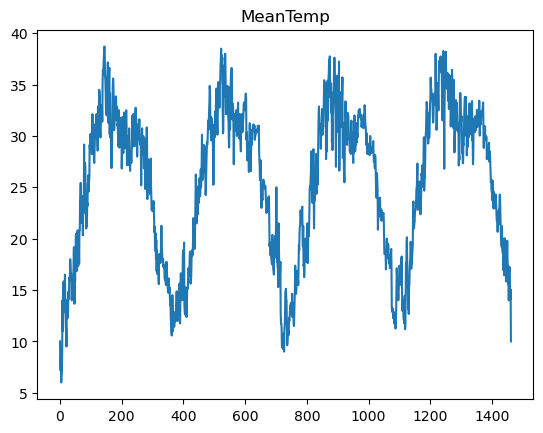

In [4]:
train.meantemp.plot()
plt.title("MeanTemp")
plt.show()

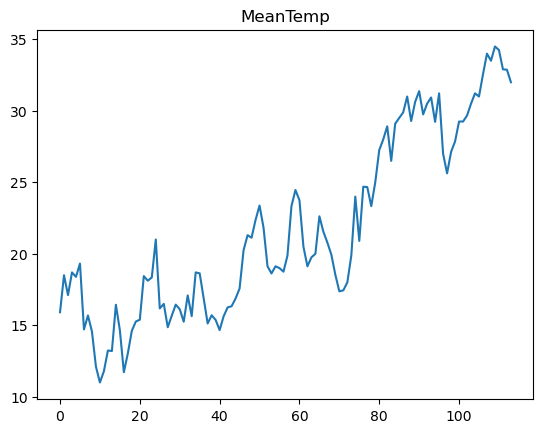

In [5]:
test.meantemp.plot()
plt.title("MeanTemp")
plt.show()

In [6]:
moving=train.rolling(window=20).mean()
moving.dropna(axis=0,inplace=True)

In [7]:
def checkStationarity(data):
    pvalue = adfuller(data['meantemp'])[1]
    print(pvalue)
    if pvalue < 0.05:
        msg = "pvalue={}. Data is Stationary. Proceed to model building".format(pvalue)
    else:
        msg = "pvalue={}. Data is not Stationary. Make the data stationary before model building".format(pvalue)

    return msg

In [8]:
checkStationarity(moving)

0.0058694177287848814


'pvalue=0.0058694177287848814. Data is Stationary. Proceed to model building'

## ACF test for best p

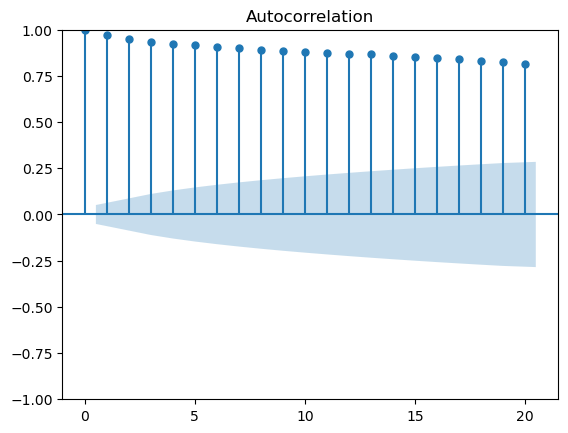

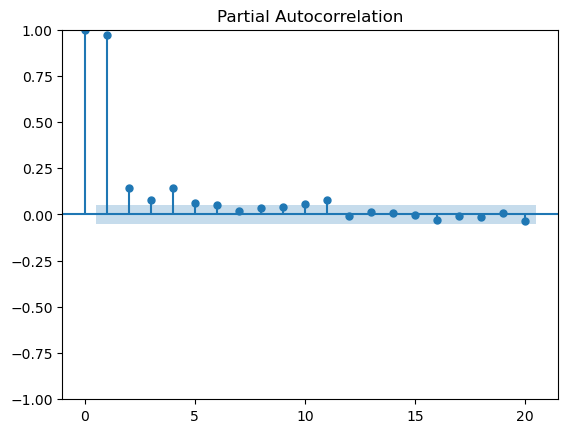

In [9]:
plot_acf(train.meantemp,lags=20);
plot_pacf(train.meantemp,lags=20);

In [10]:
from statsmodels.tsa.arima.model import ARIMA

In [11]:
for i in range(3,8):
    ar_m1 = ARIMA(train.meantemp, order = (i,0,0))
    r1 = ar_m1.fit()
    print(i,'-->',r1.aic)

3 --> 5601.026908775319
4 --> 5569.333839408018
5 --> 5562.853216949863
6 --> 5559.156848701703
7 --> 5559.952030528638


In [12]:
p=6

## MA test

In [13]:
for i in range(1,8):
    ar_m1 = ARIMA(train.meantemp, order = (1,0,i))
    r1 = ar_m1.fit()
    print(i,'-->',r1.aic)

1 --> 5602.211182716779
2 --> 5577.976147479034
3 --> 5548.704622658228
4 --> 5549.102134437428
5 --> 5550.631956164342
6 --> 5552.599061932313
7 --> 5553.987003471803


In [14]:
q=5

## ARMA test

In [15]:
import itertools
import statsmodels.api as sm

def find_best_arima_pq(data, p_range, q_range):
    p_range = list(range(1,p_range))
    q_range = list(range(1,q_range))
    
    best_aic = float('inf')
    best_model = None    
    for p, q in itertools.product(p_range, q_range):
        try:
            model = sm.tsa.ARIMA(data, order=(p, 0, q))
            results = model.fit()
            aic = results.aic
            if aic < best_aic:
                best_aic = aic
                best_model = model
                p=p
                q=q
        except:
            continue 
    best_results = best_model.fit()
    return best_results,p,q

model,p,q=find_best_arima_pq(train.meantemp,6,6)

In [16]:

predicts=model.predict(0,len(test.meantemp)-1)


In [17]:
df_res=pd.DataFrame({'actual':test.meantemp,'predicted':predicts,'errors':test.meantemp-predicts})

<AxesSubplot: >

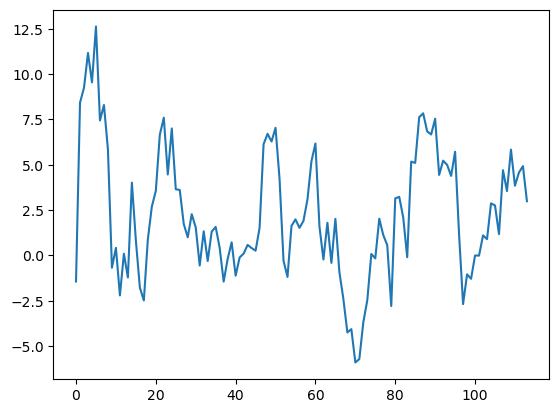

In [18]:
df_res.errors.plot()

# Calculate MSE and RMSE of the model from the test

In [21]:
# MSE
msg = 'ARMA Model. Order='+str((p,q))
mse1 = mean_squared_error(df_res.actual, df_res.predicted)
print(msg + "\n\tMSE = {}\n\tRMSE = {}".format(mse1,np.sqrt(mse1)))

ARMA Model. Order=(5, 5)
	MSE = 17.848680388642176
	RMSE = 4.224769862210506


Text(0.5, 1.0, 'ARMA Model. Order=(2,7)')

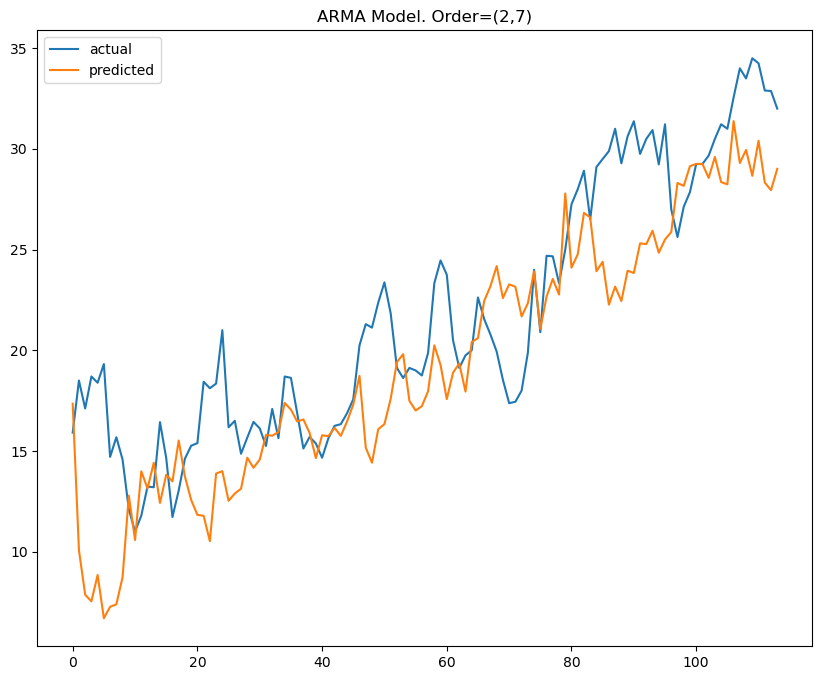

In [20]:
df_res.actual.plot(figsize=(10,8),legend=True)
df_res.predicted.plot(legend=True)
plt.title(msg)

## Conclusion:
The given output refers to an ARMA model with an order of (2,7), which suggests that the model includes two autoregressive terms and seven moving average terms.

The mean squared error (MSE) of the model is 17.848680388642176, which is a measure of how well the model fits the data. A lower MSE indicates a better fit.

The root mean squared error (RMSE) of the model is 4.224769862210506, which is the square root of the MSE. It is a commonly used measure of the model's accuracy, where a lower RMSE indicates a better fit.